In [1]:
import numpy as np
import pandas as pd
import os,time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
data_dir = '/kaggle/input/playground-series-s3e4/'
train_pth = os.path.join(data_dir,'train.csv')
train_data = pd.read_csv(train_pth)
print(train_data.shape)

(219129, 32)


In [3]:
print(train_data.columns)

Index(['id', 'Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [4]:
print(train_data.dtypes)

id          int64
Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object


In [5]:
train_data.isna().sum()

id        0
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [6]:
print(train_data.duplicated().sum())

0


In [7]:
num_cols = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

cat_cols = []

target_col = 'Class'

all_cols = num_cols + cat_cols

0    218660
1       469
Name: Class, dtype: int64


<AxesSubplot:>

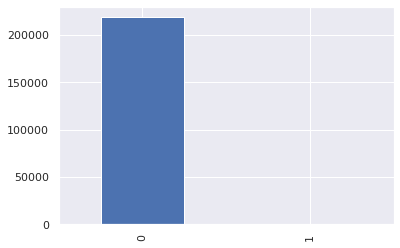

In [8]:
print(train_data[target_col].value_counts())
train_data[target_col].value_counts().plot(kind='bar')

In [9]:
df = train_data[all_cols+[target_col]].copy(deep=True)
print(df.shape)

(219129, 30)


In [10]:
df_sample = df.sample(10000)
print(df_sample.shape)

(10000, 30)


<AxesSubplot:>

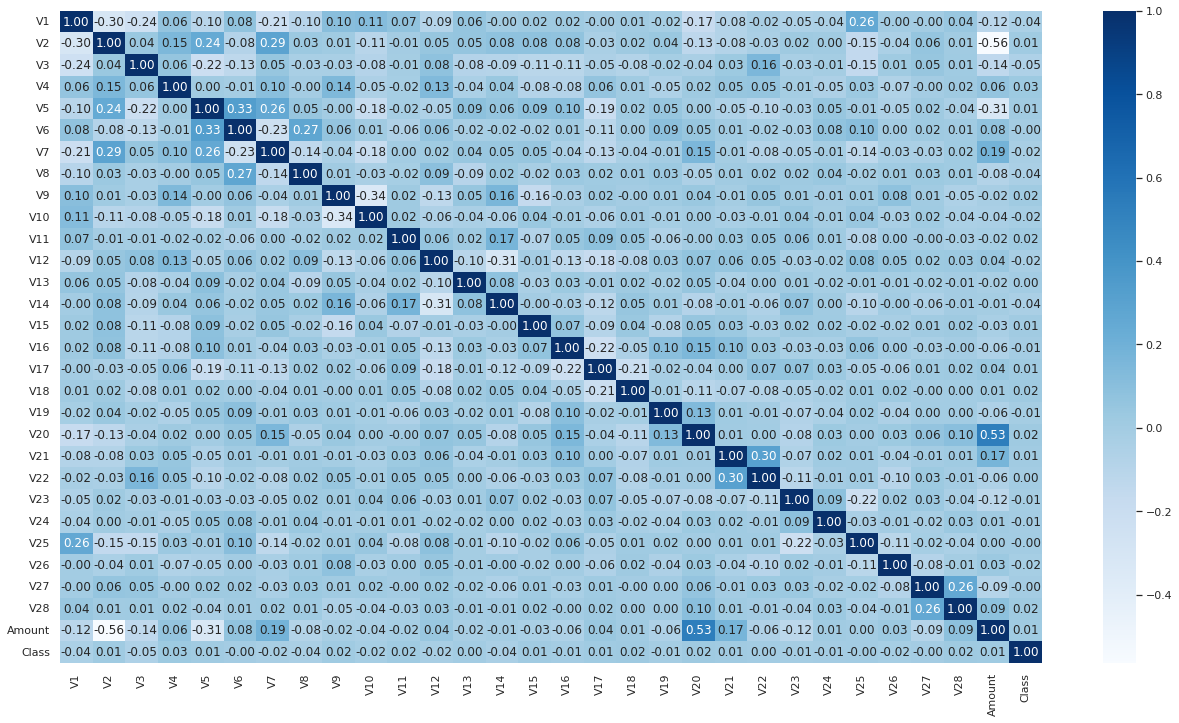

In [11]:
cor = df.corr()
_ = plt.figure(figsize=(22,12))
sns.heatmap(cor,annot=True,cmap='Blues',fmt='.2f')

In [12]:
from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder,FunctionTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score,f1_score,confusion_matrix

In [13]:
def log_transform(x):
    return np.log(1+x)

num_transformer = Pipeline(steps=[
    ('scaler',StandardScaler())
#     ('log_transform',FunctionTransformer(log_transform))
])

preprocessor = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols)
])

pipeline = Pipeline(steps=[
    ('preprocessor',preprocessor),
#     ('model',LogisticRegression(C=1000,solver='liblinear'))
#     ('model',SVC(kernel='rbf'))
#     ('model',SVC(kernel='linear',probability=True))
    ('model',xgb.XGBClassifier(max_depth=50,n_estimators=500))
#     ('model',DecisionTreeClassifier(max_depth=100))
#     ('model',RandomForestClassifier(n_estimators=100,max_depth=10))
#     ('Light GBM',lgb.LGBMClassifier(max_depth=10,n_estimators=500))
])

In [14]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [15]:
# ?RandomOverSampler

In [16]:
# rus = RandomUnderSampler(
#     sampling_strategy=0.3,
#     random_state=0,
#     replacement=False
# )

ros = RandomOverSampler(
    sampling_strategy=0.2,
    random_state=0,
)

df_,targets = ros.fit_resample(df[all_cols],df[target_col])

In [17]:
train_X,test_X,train_y,test_y = train_test_split(df_[all_cols],targets,test_size=0.1,random_state=0)
print(train_X.shape,train_y.shape)
print(test_X.shape,test_y.shape)

(236152, 29) (236152,)
(26240, 29) (26240,)


In [18]:
model  = pipeline.fit(train_X,train_y)

preds = model.predict(test_X)
pred_probs = model.predict_proba(test_X)[:,1]
print(f'ROC AUC : {roc_auc_score(test_y,pred_probs)}')
print('-------------------------------------------')
print('Confusion Matrix : ',confusion_matrix(test_y,preds))

ROC AUC : 1.0
-------------------------------------------
Confusion Matrix :  [[21954     1]
 [    0  4285]]


#### NN start

In [19]:
train_X,test_X,train_y,test_y = train_test_split(df_[all_cols].values,targets.values,test_size=0.1,random_state=0)
print(train_X.shape,train_y.shape)
print(test_X.shape,test_y.shape)

(236152, 29) (236152,)
(26240, 29) (26240,)


In [20]:
scaler = StandardScaler()

train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.fit_transform(test_X)

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [22]:
N_EPOCHS = 5
lr = 0.002
batch_size=32
n_feats = len(all_cols)
input_shape = [n_feats]
output_size = 1

d1 = 16
d2 = 32
d3 = 32
d4 = 16
d5 = output_size

In [23]:
ann_model = keras.Sequential([
    layers.Dense(units=d1,activation='relu',input_shape=input_shape),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(d2,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(d3,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(d4,activation='relu'),
    layers.Dense(d5,activation='sigmoid')
])

ann_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                480       
_________________________________________________________________
batch_normalization (BatchNo (None, 16)                64        
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1

2023-01-31 16:58:43.247442: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [24]:
loss_ = 'binary_crossentropy'
optim_ = keras.optimizers.Adam(lr)
early_stop = keras.callbacks.EarlyStopping(patience=3)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.0005,
                              patience=5, min_lr=0.05)
metrics_ = [keras.metrics.AUC(),'accuracy']

class RocCallback(keras.callbacks.Callback):
    def __init__(self,train_,val_):
        self.train_x = train_[0]
        self.train_y = train_[1]
        self.val_x = val_[0]
        self.val_y = val_[1]
        
    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return
    
    def on_epoch_end(self, epoch, logs={}):
        train_pred_probs = self.model.predict(self.train_x)
        roc_train = roc_auc_score(self.train_y,train_pred_probs)
        val_pred_probs = self.model.predict(self.val_x)
        roc_val = roc_auc_score(self.val_y,val_pred_probs)
        print('\rroc-auc_train: %s - roc-auc_val: %s' % (str(round(roc_train,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return
    
    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return
    
rocCallback = RocCallback(train_=(train_X_scaled,train_y),val_=(test_X_scaled,test_y))

In [25]:
ann_model.compile(loss = loss_,optimizer=optim_,metrics=metrics_)

In [26]:
r = ann_model.fit(train_X_scaled,train_y,
    batch_size = batch_size,
    epochs = N_EPOCHS,
    callbacks = [early_stop,rocCallback],
    validation_data = (test_X_scaled,test_y)
    )

2023-01-31 16:58:43.725742: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
7380/7380 [==============================] - 32s 4ms/step - loss: 0.3689 - auc: 0.7788 - accuracy: 0.8573 - val_loss: 0.3248 - val_auc: 0.8548 - val_accuracy: 0.8648
roc-auc_train: 0.8616 - roc-auc_val: 0.8551                                                                                                    
Epoch 2/5
7380/7380 [==============================] - 30s 4ms/step - loss: 0.3335 - auc: 0.8349 - accuracy: 0.8690 - val_loss: 0.3260 - val_auc: 0.8713 - val_accuracy: 0.8697
roc-auc_train: 0.8777 - roc-auc_val: 0.8716                                                                                                    
Epoch 3/5
7380/7380 [==============================] - 31s 4ms/step - loss: 0.3258 - auc: 0.8437 - accuracy: 0.8722 - val_loss: 0.3265 - val_auc: 0.8792 - val_accuracy: 0.8796
roc-auc_train: 0.8846 - roc-auc_val: 0.8797                                                                                                    
Epoch 4/5
7380/7380 [===================

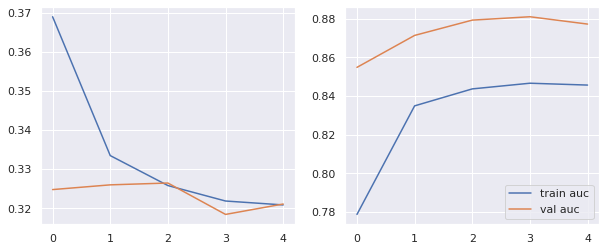

In [27]:
_,axes = plt.subplots(1,2,figsize=(10,4))
axes[0].plot(r.history['loss'],label ='train loss')
axes[0].plot(r.history['val_loss'],label='val loss')

axes[1].plot(r.history['auc'],label = 'train auc')
axes[1].plot(r.history['val_auc'],label = 'val auc')

plt.legend()
     

In [28]:
test_data = pd.read_csv(os.path.join(data_dir,'test.csv'))
print(test_data.shape)
test_data.head()

(146087, 31)


,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,219129,120580.0,2.115519,-0.691809,-1.305514,-0.685655,-0.641265,-0.764784,-0.924262,-0.023030,...,0.067367,0.241708,0.682524,0.037769,-0.546859,-0.123055,-0.084889,0.004720,-0.021944,29.95
1,219130,120580.0,1.743525,-1.681429,-0.547387,-1.061113,-0.695825,2.458824,-1.632859,1.073529,...,0.441788,0.543278,1.294571,0.309541,3.703925,-0.242579,0.068708,0.002629,0.064690,163.50
2,219131,120580.0,2.205568,-1.571445,-0.238965,-1.662517,-1.652324,-0.054701,-1.682064,0.105613,...,-0.366906,-0.131527,0.086623,0.291375,0.739087,-0.543006,-0.297813,0.043699,-0.037855,16.00
3,219132,120580.0,1.989728,-0.972909,-1.938259,-1.440129,-0.166855,-0.794048,0.252889,-0.399789,...,-0.049136,-0.080115,-0.010732,-0.038550,0.656830,0.343470,-0.627529,-0.024338,-0.036143,120.98
4,219133,120580.0,-1.943548,-1.668761,0.363601,-0.977610,2.684779,-2.037681,0.039709,-0.048895,...,0.391627,0.083389,-0.306918,0.247822,-0.391799,-0.790716,-0.025706,0.330758,0.335537,1.98


In [29]:
## Predict ANN

X = test_data[all_cols].values
X_scaled = scaler.transform(X)
preds = ann_model.predict(X)
test_data['Class'] = preds[:,0]
subs = test_data[['id','Class']]
subs.to_csv('subs1.csv',index=False)

In [30]:
## Predict Sk learn model
X = test_data[all_cols]
preds = model.predict_proba(X)
test_data['Class'] = preds[:,1]
subs = test_data[['id','Class']]
subs.to_csv('subs1.csv',index=False)

In [31]:
(preds[:,0] > 0.5).sum()

146070

In [32]:
preds[:,0][:10]

array([0.99999756, 0.99997306, 0.999989  , 0.99996036, 0.9999985 ,
       0.9999985 , 0.99999565, 0.9999973 , 0.9999872 , 0.99999523],
      dtype=float32)